# Meteor Project - Sporadic Meteors

In this script we define in a SPICE kernel called "earth_sun.tf" (can be found in the kernels folder), a co-rotating coordiante system that is aligned with Earth's rotation around the Sun. That way, we will see particular meteor sources w.r.t. directions of interest like the Apex or Anti-Helion direction.

## Get and prepare the data

In [1]:
# Importing libraries
from matplotlib import pyplot as plt
import matplotlib.animation
import numpy as np
import pandas as pd

import datetime
import math
import os

In [2]:
# Read in the meteor data
df_orbit_compl = pd.read_csv("meteor_data/meteor_compl.csv",
                             index_col=0)
df_orbit_error = pd.read_csv("meteor_data/meteor_error.csv",
                             index_col=0)

df_radiants = pd.concat([df_orbit_compl[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]],
                         df_orbit_error[["RA", "DECL", "Vg", "Yr", "Mn", "Dayy"]]])

# Now filter
df_radiants = df_radiants.loc[(df_radiants["Vg"]>=11) & (df_radiants["Vg"]<=73)].copy()

# Convert to radians
df_radiants.loc[:, "RA_rad"] = np.radians(df_radiants["RA"])
df_radiants.loc[:, "DECL_rad"] = np.radians(df_radiants["DECL"])

# First we add a datetime object column:
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: datetime.datetime(year=int(x["Yr"]),
                                                  month=int(x["Mn"]),
                                                  day=math.floor(x["Dayy"])),
                                                  axis=1)

# Add now the day's fraction
df_radiants.loc[:, "datetime"] = \
    df_radiants.apply(lambda x: x["datetime"] + datetime.timedelta(days=x["Dayy"]%1), axis=1)

# Add a Day of Year (DOY) column, based on the datetime column
df_radiants.loc[:, "doy"] = df_radiants.datetime.dt.day_of_year.copy()

In [3]:
# Load SPICE kernels
import spiceypy
spiceypy.furnsh("../kernels/lsk/naif0012.tls")
spiceypy.furnsh("../kernels/spk/de432s.bsp")
spiceypy.furnsh("../kernels/fk/earth_sun.tf")

In [4]:
# Compute emphermis time
df_radiants.loc[:, "ET"] = \
    df_radiants.apply(lambda x: spiceypy.utc2et(x["datetime"].strftime("%Y-%m-%dT%H:%M:%S")),
                                                axis=1)

## Create co-rotating radiants

In [5]:
# This function takes the RA and DEC values, given in J2000 and converts them in our new
# coordiante system called "EARTH_SUN".
def j2000_2_earthr(ra_radians, dec_radians, et):

    # Convert J2000 into a 3D vector
    rectan = spiceypy.radrec(1.0, ra_radians, dec_radians)

    # Compute a matrix that converts a vector in J2000 to EARTH_SUN
    tf_matrix = spiceypy.pxform("J2000", "EARTH_SUN", et)

    # Apply the transformation on the vector, and convert the resulting vector back to RA / DEC
    rectan_t = tf_matrix.dot(rectan)
    _, ra_earthr_radians, dec_earthr_radians = spiceypy.recrad(rectan_t)
    
    return ra_earthr_radians, dec_earthr_radians

In [6]:
# Add 2 new columns that contain RA and DEC values in EARTH_SUN
df_radiants.loc[:, "RA_earthr_rad"] = \
    df_radiants.apply(lambda x: j2000_2_earthr(x["RA_rad"], x["DECL_rad"], x["ET"])[0], axis=1)

df_radiants.loc[:, "DECL_earthr_rad"] = \
    df_radiants.apply(lambda x: j2000_2_earthr(x["RA_rad"], x["DECL_rad"], x["ET"])[1], axis=1)

In [7]:
# Add a column for the plot
df_radiants.loc[:, 'RA_earthr_rad4plot'] = \
    df_radiants['RA_earthr_rad'].apply(lambda x: -1*((x % np.pi) - np.pi) if x > np.pi else -1*x)

## Sky Plot

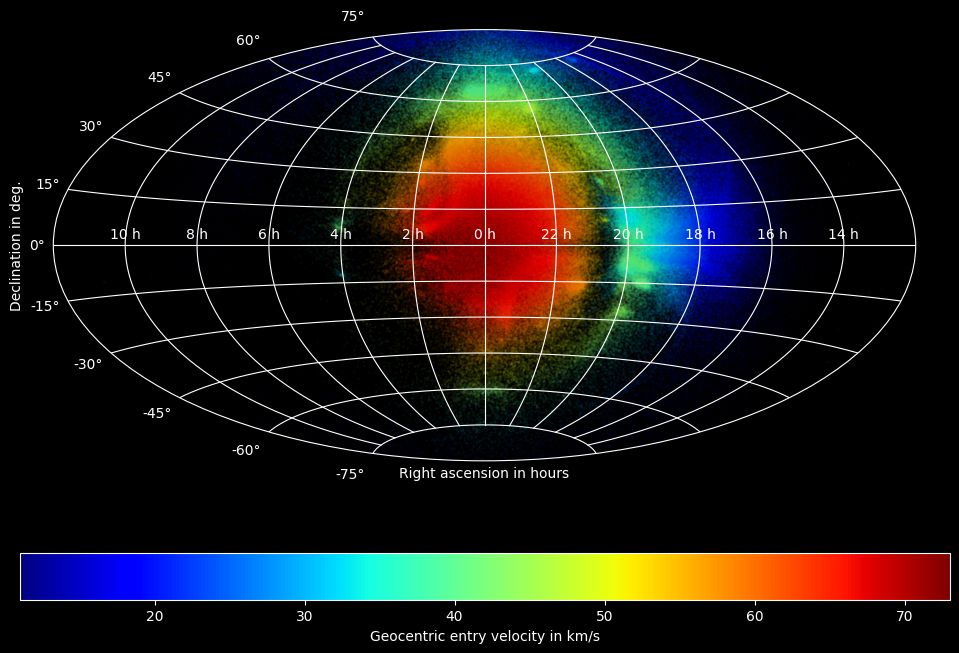

In [8]:
# Add some styles
plt.style.use('dark_background')
fig = plt.figure(figsize=(12, 8))

# Add aitoff projection
plt.subplot(projection="aitoff")

# Get axes
ax = plt.gca()

# Add a color for the velocity values
cm = plt.colormaps.get_cmap('jet')

# Plot the radiants
cr = plt.scatter(df_radiants['RA_earthr_rad4plot'], \
                 df_radiants['DECL_earthr_rad'], linestyle='None', \
                 s=1, c=df_radiants["Vg"], cmap=cm, alpha=0.03)

# Create a colormap
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(min(df_radiants["Vg"].values),
                                                       max(df_radiants["Vg"].values)))

# Convert the longitude values finally in right ascension hours
plt.xticks(ticks=np.radians(np.arange(-150, 180, 30)),
           labels=['10 h', '8 h', '6 h', '4 h', '2 h', '0 h', \
                   '22 h', '20 h', '18 h', '16 h', '14 h'])

# Plot the labels
plt.xlabel('Right ascension in hours')
plt.ylabel('Declination in deg.')

# Add a grid
plt.grid(True)

# Add the colorbar
ax = plt.gca()
color_bar = fig.colorbar(sm, orientation='horizontal', ax=ax)
color_bar.set_alpha(1)
color_bar.set_label('Geocentric entry velocity in km/s')

fig.savefig("dir_of_interests_corot.png")